# Download model variables

Download as raster layers covering your study area envelope, including:

- At least one **soil** variable from the [POLARIS dataset](http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/) (**find thresholds**)
    - [POLARIS: 30-meter probabilistic soil series map of contiguous US](https://pubs.usgs.gov/publication/70170912)
    - <https://scholars.duke.edu/publication/1381493>
    - <https://gee-community-catalog.org/projects/polaris/>
    - NW Chaney et al. (2019) POLARIS Soil Properties: 30-m Probabilistic Maps of Soil Properties Over the Contiguous United States. [DOI: 10.1029/2018WR022797](https://doi.org/10.1029/2018WR022797)
    - Elsa Culler EarthLab Videos
        - [Accessing and formatting URLS for POLARIS data](https://cuboulder.zoom.us/rec/share/imhCGJcrCgSoE1cJjg02r86GMNjiRz0jwVMJ5c0uWNwBCD5D_0kLSl3CaqLdDI2a.ucGta1EEAiirDUop)
        - [Looping through multiple tiles of POLARIS data](https://cuboulder.zoom.us/rec/share/3S7pGOSv7jztZTvg4RSXLj-GicnHwusIDIEDoETZbUN7ivkc6Ryi5GAJyX9Ly6h2.VXl6iFmLChjjUyOg)
- Elevation from the SRTM (available from the [earthaccess API](https://github.com/nsidc/earthaccess/))
- At least one **climate** variable from the [MACAv2 THREDDS data server](http://thredds.northwestknowledge.net:8080/thredds/reacch_climate_CMIP5_macav2_catalog2.html).
    - Pick 2 of these
    - [GeoNetwork](https://docs.geonetwork-opensource.org/4.2/):
[THREDDS Harvesting](https://docs.geonetwork-opensource.org/4.2/user-guide/harvesting/harvesting-thredds/)

## POLARIS Dataset

Considering `sand` percentage `mean`. POLARIS data are available at 6 depths, and Bluestem has roots down to 5 feet (150 cm), which is the lowest strata measured (100-200 cm). Data in the
[sand 100-200 cm directory](http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/sand/mean/100_200/)
are saved as separate tif files by longitude.
Buvvalo Gap National Grassland is at (centroid) 43.4375° N, 103.0505° W, while Oglala National Grassland is at 42.9404° N, 103.5900° W. That probably suggests

- [lat4344_lon-103-102.tif](http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/sand/mean/100_200/lat4344_lon-103-102.tif) (33M)
- [lat4344_lon-104-103.tif](http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/sand/mean/100_200/lat4344_lon-104-103.tif) (33M)

In [16]:
import os
import pathlib
from math import floor, ceil

import geopandas as gpd
import rioxarray as rxr

In [7]:
pip install ~/Documents/GitHub/landmapy

Processing /Users/brianyandell/Documents/GitHub/landmapy
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for landmapy: filename=landmapy-0.2-py3-none-any.whl size=20615 sha256=9c98ad3e7bf3dcff1c6b5a87aede63e51938b793ab5362de3e4f698703e3b758
  Stored in directory: /private/var/folders/tt/cyd1sy9s18l1fgc_0ty8l91w0000gn/T/pip-ephem-wheel-cache-icqsmamj/wheels/d4/8b/49/f05ffe83c93ff1cc194a4161d132e5ba0632f5ae288edbcd13
Successfully built landmapy
  Attempting uninstall: landmapy
    Found existing installation: landmapy 0.2
    Uninstalling landmapy-0.2:
      Successfully uninstalled landmapy-0.2
Note: you may need to restart the kernel to use updated packages.


### Single POLARIS TIFF

In [27]:
soil_url = (
    "http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/"
    "sand/"
    "mean/"
    "100_200/"
    "lat4344_lon-105-104.tif"
)
soil_url

'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/sand/mean/100_200/lat4344_lon-105-104.tif'

In [28]:
soil_da = rxr.open_rasterio(
    soil_url,
    mask_and_scale=True
).squeeze()
soil_da

<xarray.DataArray (y: 3600, x: 3600)> Size: 52MB
[12960000 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 29kB -105.0 -105.0 -105.0 ... -104.0 -104.0 -104.0
  * y            (y) float64 29kB 44.0 44.0 44.0 44.0 ... 43.0 43.0 43.0 43.0
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area

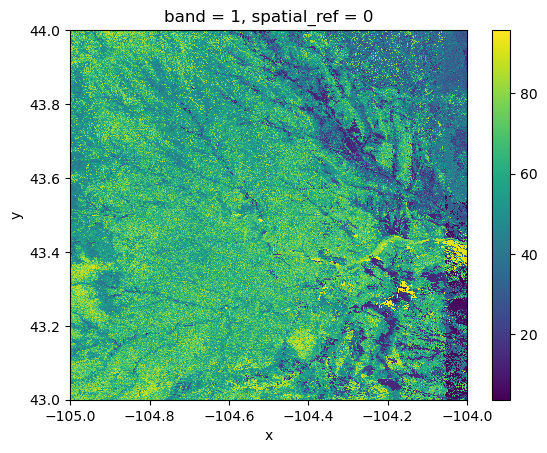

In [29]:
soil_da.plot()

### Multiple POLARIS TIFFs

Get boundary for study. Fake Denver for now.
Determine `lat` and `lon` based on site.
Set up `for` loop.

<Axes: >

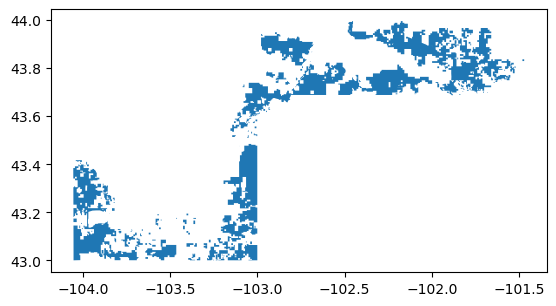

In [10]:
%store -r buffalo_gdf
buffalo_gdf.plot()

In [11]:
buffalo_gdf.total_bounds

array([-104.05473027,   43.00062297, -101.47233564,   43.99459902])

In [21]:
def soil_urls(place_gdf, soil_var="sand", soil_sum="mean", soil_depth="100-200"):
    """
    Set up soil URLs based on place.
    
    Parameters
    ----------
        place_gdf: GeoDataFrame
            GeoDataFrame of selected location
        soil_var, soil_sum, soil_depth: character string
            Name of soil variable, summary and depth

    Results
    -------
        blah: character string
    """
    from math import floor, ceil
    
    soil_url_template = (
        "http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/"
        f"{soil_var}/"
        f"{soil_sum}/"
        f"{soil_depth}/"
        "lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif")
    
    # soil_url_template.format(min_lat = 43, max_lat = 44, min_lon = -103, max_lon = -104)

    bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat = (place_gdf.total_bounds)

    soil_url_list = []
    for min_lon in range(floor(bounds_min_lon), ceil(bounds_max_lon)):
        for min_lat in range(floor(bounds_min_lat), ceil(bounds_max_lat)):
            print(min_lon, min_lat)
            soil_url = soil_url_template.format(min_lat = min_lat, max_lat = min_lat + 1,
                min_lon = min_lon, max_lon = min_lon + 1)
            soil_url_list.append(soil_url)

    return soil_url_list

# soil_url_list = soil_urls(place_gdf, soil_var="sand", soil_sum="mean", soil_depth="100-200")

In [23]:
buffalo_urls = soil_urls(buffalo_gdf)

-105 43
-104 43
-103 43
-102 43


can download in list and merge as before (see redlining `merge_das`)

In [26]:
buffalo_urls[0]

'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/sand/mean/100-200/lat4344_lon-105-104.tif'

In [30]:
import rioxarray as rxr

data_array = rxr.open_rasterio(buffalo_urls[0],
    mask_and_scale=True).squeeze()

RasterioIOError: HTTP response code: 404